# Turing Target Practice

## Model

In [24]:
] activate "."

  Activating project at `~/PhD/MCHMC.jl`


In [25]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using StatsPlots
using PyPlot

using Revise
using MCHMC

In [26]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [27]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [28]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Normal(0.3, 0.1)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [29]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [30]:
target = TuringTarget(stat_model);

In [31]:
mchmc = Sampler(0.0, 0.0, varE_wanted=2.0) #sqrt(target.d)*0.01

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [32]:
samples_mchmc = Sample(mchmc, target, 10000;
                       monitor_energy=true, 
                       dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 106.44933853158048
eps: 0.125 --> VarE: 27.956356234704963
eps: 0.0625 --> VarE: 9.346881457932355
eps: 0.03125 --> VarE: 2.345686762647545
eps: 0.015625 --> VarE: 1.0015404985644927


[ Info: Found eps: 0.015625 ✅
[ Info: Tuning L ⏳


samples: 100--> ESS: 0.1081719926266478


[ Info: Found L: 1.4142135623730951 ✅


10001-element Vector{Any}:
 [0.16126367762377306, 0.6134838944338891, 0.0, -12.63747523747612]
 [0.16126367762377306, 0.6134838944338891, 4.100665713781904, -8.53744646911858]
 [0.172241786402598, 0.6246024263801617, 11.449460676088142, -4.859974494420379]
 [0.18456999165756016, 0.6342022170128538, 8.680259685857603, -1.7331305782349857]
 [0.1886973185124843, 0.6492722468082001, 8.054986154370177, 1.4397885525166012]
 [0.19898158868726018, 0.661035512170004, 8.810758566617173, 4.255327661833728]
 [0.20550546474149037, 0.67523338758251, 7.769451202285431, 6.834479537142449]
 [0.21665046140221278, 0.6861846283538786, 7.36110423330349, 9.162703321823296]
 [0.2243331562753066, 0.6997903927383936, 6.635869395162805, 11.223241551817175]
 [0.23123120901015576, 0.7138102890813499, 4.613027178050969, 12.129398332364048]
 [0.2239927236152563, 0.7276574893105597, 2.1623095105278693, 13.223219082611328]
 [0.21957328312414767, 0.7426444560065109, 3.215812279191832, 14.720032969610394]
 [0.232604492

In [33]:
#plt.plot(samples_mchmc.E[8000:end])

In [34]:
#mean(samples_mchmc.E[8000:end])

In [35]:
#std(samples_mchmc.E[8000:end])^2/target.d

In [36]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

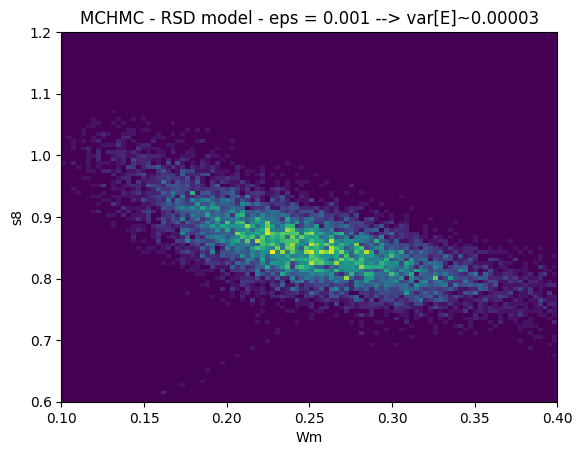

In [37]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model - eps = 0.001 --> var[E]~0.00003");

## AbstractMCMC

In [65]:
mchmc = Sampler(0.0, 0.0, varE_wanted=2.0)

Sampler(Settings(Random.MersenneTwister(0), 2.0, 0, 1000, 10, "LF"), Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836), MCHMC.Leapfrog)

In [66]:
samples = sample(
    stat_model, mchmc, 10000;
    monitor_energy=true, 
    dialog=true)

[ Info: Tuning eps ⏳


eps: 0.5 --> VarE: NaN
eps: 0.25 --> VarE: 119.68629364995823
eps: 0.125 --> VarE: 23.73638207859411
eps: 0.0625 --> VarE: 4.886733555017032
eps: 0.03125 --> VarE: 1.95942620582855
samples: 100--> ESS: 0.3077596520088519


[ Info: Found eps: 0.03125 ✅
[ Info: Tuning L ⏳
[ Info: Found L: 1.4142135623730951 ✅
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.42 seconds
Compute duration  = 1.42 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2511    0.0567     0.0006    0.0024   572.2042    1.0066     ⋯
          σ8    0.8529    0.0532     0.0005    0.0021   611.2232    1.0020     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1532    0.2107    0.2465    0.2873    0.3725
          σ8    0.7544    0.8164    0.8504    0.8874    0.9635


In [67]:
new_samples = sample(stat_model, mchmc, 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.94 seconds
Compute duration  = 0.94 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2499    0.0572     0.0006    0.0024   595.0984    1.0000     ⋯
          σ8    0.8551    0.0539     0.0005    0.0021   628.4278    1.0002     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1457    0.2097    0.2468    0.2871    0.3690
          σ8    0.7562    0.8179    0.8527    0.8892    0.9687


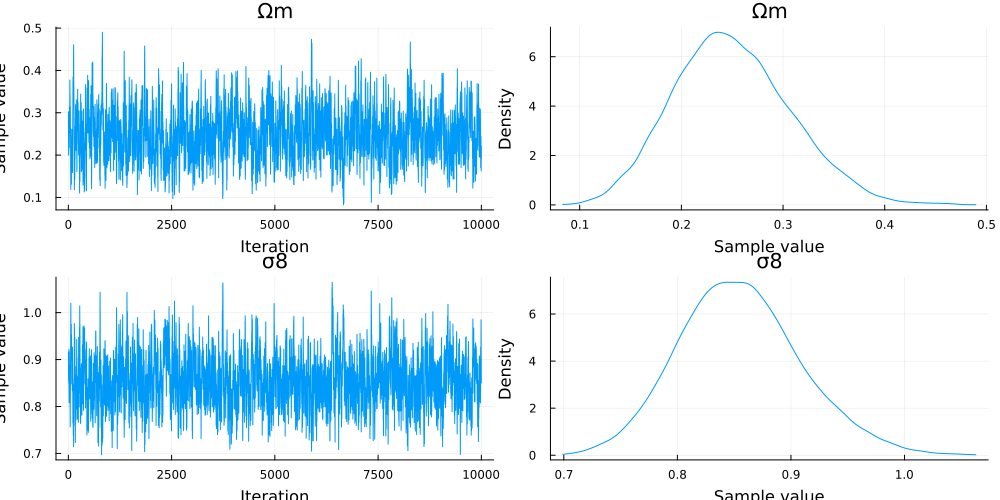

In [76]:
StatsPlots.plot(new_samples)

## NUTS

In [68]:
samples_hmc = sample(stat_model, NUTS(500, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 6.82 seconds
Compute duration  = 6.82 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2511    0.0602     0.0006    0.0012   2715.2774    1.0002    ⋯
          σ8    0.8544    0.0568     0.0006    0.0011   2480.6458    1.0004    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [69]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 501:1:10500
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.244027  0.881585  18.5855  3.0  1.0  …  1.0  0.0  0.691222  0.691222
 0.259477  0.804809  18.3808  7.0  1.0     2.0  0.0  0.691222  0.691222
 0.258136  0.828204  18.811   3.0  1.0     2.0  0.0  0.691222  0.691222
 0.188475  0.916995  18.3162  5.0  1.0     2.0  0.0  0.691222  0.691222
 0.239157  0.838397  18.824   7.0  1.0     2.0  0.0  0.691222  0.691222
 0.297914  0.839382  18.3663  5.0  1.0  …  2.0  0.0  0.691222  0.691222
 0.297914  0.839382  18.3663  1.0  1.0     1.0  0.0  0.691222  0.691222
 0.295994  0.831967  18.4946  3.0  1.0     2.0  0.0  0.691222  0.691222
 0.279726  0.804005  18.4838  7.0  1.0     3.0  0.0  0.691222  

In [70]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

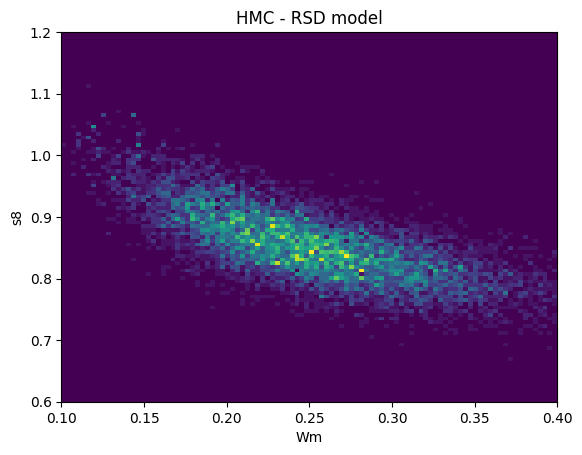

In [71]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");